<a href="https://colab.research.google.com/github/Timmmy88880/datascience/blob/main/Netflix_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
import seaborn as sns
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from sklearn.preprocessing import MinMaxScaler




In [3]:
#from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np

data  = pd.read_csv("/content/drive/MyDrive/資料科學/Netflix.csv")

data.head(1)

Mounted at /content/drive


,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
0,1,Basic,10,15-01-22,10-06-23,United States,28,Male,Smartphone,1 Month


In [4]:
#Remove unnecesary ID
data = data.drop(["User ID"],axis=1)
data.head(1)

,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
0,Basic,10,15-01-22,10-06-23,United States,28,Male,Smartphone,1 Month


In [5]:
#Check distinct values of plan duration
data['Plan Duration'].unique()

array(['1 Month'], dtype=object)

In [6]:
#Check distinct values of plan duration
data['Subscription Type'].unique()

array(['Basic', 'Premium', 'Standard'], dtype=object)

In [7]:
# Convert columns to datetime data type
data['Join Date'] = pd.to_datetime(data['Join Date'])
data['Last Payment Date'] = pd.to_datetime(data['Last Payment Date'])

# Calculate the difference in days
data['days_subscribed'] = (data['Last Payment Date'] - data['Join Date']).dt.days

In [8]:
data.head(1)

,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration,days_subscribed
0,Basic,10,2022-01-15,2023-10-06,United States,28,Male,Smartphone,1 Month,629


In [9]:
#Remove fields that were consolidated to new metric
data = data.drop(["Last Payment Date","Join Date"],axis=1)

In [10]:
data.head(1)

,Subscription Type,Monthly Revenue,Country,Age,Gender,Device,Plan Duration,days_subscribed
0,Basic,10,United States,28,Male,Smartphone,1 Month,629


In [11]:
#Removing Label column and plan duration as it has only the same value
data_customer = data.drop(["days_subscribed","Plan Duration"],axis=1)
data_customer.head(1)

,Subscription Type,Monthly Revenue,Country,Age,Gender,Device
0,Basic,10,United States,28,Male,Smartphone


In [12]:
data_labels = data["days_subscribed"]
data_labels.head(1)

0    629
Name: days_subscribed, dtype: int64

In [13]:
data_customer_encoded = pd.get_dummies(data_customer, columns=['Subscription Type', 'Country','Gender','Device'])
data_customer_encoded.head(1)

,Monthly Revenue,Age,Subscription Type_Basic,Subscription Type_Premium,Subscription Type_Standard,Country_Australia,Country_Brazil,Country_Canada,Country_France,Country_Germany,...,Country_Mexico,Country_Spain,Country_United Kingdom,Country_United States,Gender_Female,Gender_Male,Device_Laptop,Device_Smart TV,Device_Smartphone,Device_Tablet
0,10,28,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0


In [14]:
# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(data_customer_encoded)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, data_labels, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2000, 21)
(500, 21)
(2000,)
(500,)


In [15]:
# Build NN
tf.random.set_seed(42)
model = tf.keras.Sequential()
#Specify input shape
model.add(tf.keras.layers.Dense(4,'relu',input_shape=(21,)))
model.add(tf.keras.layers.Dense(4,'relu'))
model.add(tf.keras.layers.Dense(1,None))
#2.Compile the model use mean absolute layer as loss function as it tends to perform well on regression models
model.compile(loss=tf.keras.losses.mae,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0015),
              metrics="mae")
#3.Train model and save historical data
history = model.fit(tf.expand_dims(X_train, axis=-1),y_train,epochs=5000,verbose=0)

In [16]:
from sklearn.metrics import mean_absolute_error
# Predict on test data
predictions = model.predict(X_test)
# Calculate MAE for test data
mae = mean_absolute_error(y_test, predictions)
# Print the MAE
print("Mean Absolute Error:", mae)

16/16 [==============================] - 0s 2ms/step
Mean Absolute Error: 93.76050912475586


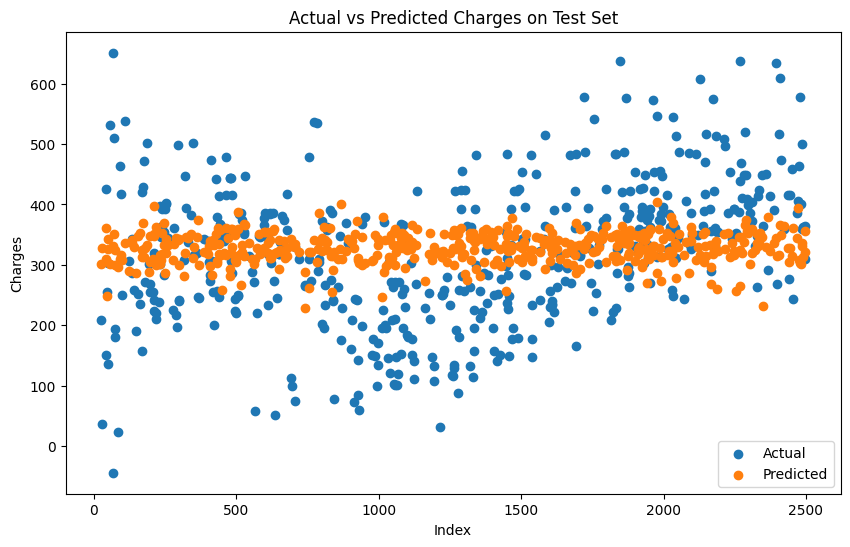

In [17]:
import matplotlib.pyplot as plt
# Create a DataFrame for actual and predicted values
results = pd.DataFrame({"Actual": y_test, "Predicted": predictions.flatten()})

# Plot the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(results.index, results["Actual"], label="Actual")
plt.scatter(results.index, results["Predicted"], label="Predicted")
plt.xlabel("Index")
plt.ylabel("Charges")
plt.title("Actual vs Predicted Charges on Test Set")
plt.legend()
plt.show()

The model currently predicts with a MAE of 36 (days) for training data and 76 (days) for test data. Given the dataset isn't extensive this result is positive as being able to predict customer retention based on known factors can be a big win to a company. This model of course does not take other parameters into consideration that could provide more insight like customer satisfaction, time spent on the app, content engagement and other metrics that would make it more aplicable to a real life scenerio.